# Q-Learning and Sarsa: The Cliff

On this example we will use Sarsa and Q-learning to obtain the optimal policy in a slightly more difficult problem. In this problem, our environment is a small grid, and the agent needs to walk from the bottom left corner of the grid, to the bottom right, while avoiding falling into the cliff.


![cliff.png](attachment:cliff.png)

Each valid step yields a negative reward of -1, except when falling off the cliff, that yields a negative reward of -100 and ends the episode. Each invalid step (going through a wall) yields a negative reward of -1 and leaves the agent in the same place. It the goal is achieved, reward is 100 and the episode ends.

# 1. Import libraries and environment

First we need to import the python libraries that will be used along the notebook.
We will use Numpy:

In [1]:
import numpy as np # Numpy is the standard Python library to do operation with arrays.

as well as our own CliffWalking enviroment. You are encouraged to look at the environment file. However, from the enviroment we will only use three functions:

    1.reset: resets the enviroment's variables and returns the initial observation
    
    2.step: performs an action and returns the observation
    
    3.visualize: visualizes a game through matplotlib 

In [2]:
from CliffWalking import CliffWalking # CliffWalking is the enviroment we created for this example

# 2. The Agent class

We will implemment an agent class, that will be able to play the game by generating episodes on training mode or testing mode.

# 2.1 Initialize the agent and enviroment

For that we need to set:

Enviroment's variables: the size of the cliff, number of available actions and optimal score.

Exploration's variables: epsilon marks the probability the agent performs a random action. As they gather more knowledge over the enviroment, this probability decreases to a minimum, as their prediction accuracy increases and becomes more reliable. 

Update's variables: alpha is the learning rate of the agent and gamma the dicount rate.

Policy: Q is a dict that pairs states with the Q-values for each action on that state.


In [3]:
class Agent(): 
    def __init__(self, size, lm='SARSA'):
        
        #enviroment 
        self.grid_size = size
        self.env = CliffWalking(self.grid_size) #Initializing the enviroment
        self.action_space = [0,1,2,3]
        self.actions_num = len(self.action_space)
        self.optimal_score = self.env.goal_reward - self.grid_size[1]
        
        #exploration
        self.epsilon = 0.1
        
        #update 
        self.alpha = 0.05
        self.gamma = 1.0
        
        #policy
        self.Q_sa = np.zeros((size[0],size[1],self.actions_num))#defaultdict(lambda: np.zeros(self.actions_num))
        
        #modes
        self.learning_method = lm 
        
        
    def greedy_policy(self, s):
        """ For a given state, s, the greedy policy takes the action that 
        maximises Q(s, a) 
        """
        return np.argmax(self.Q_sa[s])

    def random_policy(self):
        """ The random policy takes an action at random. In TinyWorld, there
        are always two possible actions (left, right) """
        return np.random.choice(4) #self.action_space)

    def e_greedy_policy(self, s):
        """ This policy takes a random action with probability epsilon,
        and otherwise it follows the greedy policy """
        if np.random.rand() < self.epsilon:
            return self.random_policy()
        else:
            return self.greedy_policy(s)
    
    def choose_action(self, s, test=False):
        if not test:
            return self.e_greedy_policy(s)
        else:
            return self.greedy_policy(s)


# 2.3 Update Policies

After performing the chosen action and observing the results, they need to evaluate whether or not that action was beneficial. If it was, the update function is going to reinforce it.

# 2.3a Update Q-Learning

The update function for Q-Learning is the following:
![Screenshot%20from%202018-12-07%2015-45-33.png](attachment:Screenshot%20from%202018-12-07%2015-45-33.png)
which is easily implemented as follows:

In [4]:
def update_policy_QL(self, current_state, next_state, action, reward):
    self.Q_sa[current_state][action] += self.alpha * (reward + self.gamma * np.max(self.Q_sa[next_state]) - self.Q_sa[current_state][action])

Agent.update_policy_QL = update_policy_QL


# 2.3b Update Sarsa

The update function for Sarsa is quite similar with one major difference.

Since it's an on-policy method, the agent uses the same policy to predict actions and evaluate them: 

![Screenshot%20from%202018-12-07%2015-45-33-2.png](attachment:Screenshot%20from%202018-12-07%2015-45-33-2.png)

So instead of getting the best next_action for the next_state greedily from a second policy as on Q-Learning (through 'max'), the agent will use the same policy to predict the next_action, update and then return it so that it will be performed on the next timestep:

In [5]:
def update_policy_Sarsa(self, current_state, next_state, action, next_action, reward):
    self.Q_sa[current_state][action] += self.alpha * (reward + self.gamma * self.Q_sa[next_state][next_action] - self.Q_sa[current_state][action])
        
Agent.update_policy_Sarsa = update_policy_Sarsa

# 2.4 Printing the results

For simplicity, we define three functions for printing the name of method under which we train, the best and average score, as well as visualize a game:


In [6]:
def print_method(self):
    print('Training using', self.learning_method, 'method:\n')
        
def print_best(self, best_score):
    print("Using", self.learning_method, "generated best score: ",best_score)
    if best_score == agent.optimal_score:
        print("which is optimal!")

def print_game(self, best_episode):
    self.env.visualize(best_episode) #show history of best episode
            
Agent.print_method = print_method
Agent.print_best = print_best
Agent.print_game = print_game

# 3. Training by Playing the Game

We are going to use the agent class, to generate an episode using the basic principals:

A. for 100 timesteps repeat:
    1. choose an action based on policy
    2. perform said action and observe results
    3. log the results for later use
    4. update the policy based on observation
    5. if the goal was reached: finish the for loop
B. return game history

which in Python, looks like this:

In [7]:
def generate_episode(self, test=False): #Runs an episode and returns the history, total score and success
    state = self.env.reset()
    action = self.choose_action(state, test)
    score = 0
    episode = []

    for t in range(100):
        next_state, reward, done = self.env.step(action)
        episode.append((state, action, reward))
        score += reward

        next_action = self.choose_action(next_state, test)
            
        if not test: #update policy based on new observation
            if self.learning_method == "QL":
                self.update_policy_QL(state, next_state, action, reward) # Note that we do not use next action
            elif self.learning_method == "SARSA":
                self.update_policy_Sarsa(state, next_state, action, next_action, reward)
            else:
                raise Exception
            
        if done:
            break
        
        action = next_action
        state = next_state
        
    return episode, score, done
        
Agent.generate_episode = generate_episode

# 4. Testing the Policy

We are going to test the policy's acurracy, by generating episodes with the previous function, but with the explore and learn boolean flags switched off.

That way:
    1. With explore = False, the agent always chooses an action greedily.
    2. With learn = False, the agent doesn't update the policy.
    
So we get:

In [8]:
def generate_test_episode(self):
    episode, score, done = generate_episode(self, test=True)
    return episode, score, done

Agent.generate_test_episode = generate_test_episode

def test(self, i): #Every eval_frequency episodes, test our policy, by disabling learning and exploration
    if i%eval_frequency==0 and not i==0 or i == total_episodes-1:
        test_score = 0
        for _ in range(eval_episodes):
            history, score, done = generate_test_episode(self)
            test_score += score
            
        print("During testing, average score is ", test_score/eval_episodes)


Agent.test = test

# 5. Putting things together

We specify the number of episodes for the taining and testing trials, and the evaluation frequency:

In [9]:
total_episodes = 2000 #number of training episodes
eval_frequency = 100 #evaluate every 100 training episodes,
eval_episodes = 1 #by running 1 episode on test mode

Only thing left, is the main loop. We create the agent class in a for loop, once for every method and then alternate between training and testing, while printing the results:

Training using QL method:

During testing, average score is  -100.0
During testing, average score is  -100.0
During testing, average score is  -100.0
During testing, average score is  -12.0
During testing, average score is  -100.0
During testing, average score is  -100.0
During testing, average score is  -100.0
During testing, average score is  -100.0
During testing, average score is  -12.0
During testing, average score is  -12.0
During testing, average score is  -12.0
During testing, average score is  -12.0
During testing, average score is  -12.0
During testing, average score is  -12.0
During testing, average score is  -12.0
During testing, average score is  -12.0
During testing, average score is  -12.0
During testing, average score is  -12.0
During testing, average score is  -12.0
During testing, average score is  -12.0
Using QL generated best score:  -12.0
which is optimal!
Average of scores during training: -43.982
Episode run using the greedy policy and the final action-value func

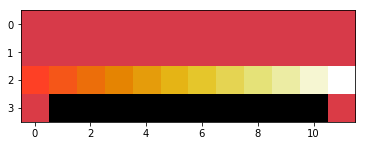

Training using SARSA method:

During testing, average score is  -100.0
During testing, average score is  -100.0
During testing, average score is  -100.0
During testing, average score is  -100.0
During testing, average score is  -16.0
During testing, average score is  -100.0
During testing, average score is  -100.0
During testing, average score is  -14.0
During testing, average score is  -14.0
During testing, average score is  -14.0
During testing, average score is  -14.0
During testing, average score is  -100.0
During testing, average score is  -14.0
During testing, average score is  -14.0
During testing, average score is  -100.0
During testing, average score is  -14.0
During testing, average score is  -14.0
During testing, average score is  -14.0
During testing, average score is  -14.0
During testing, average score is  -14.0
Using SARSA generated best score:  -14.0
Average of scores during training: -31.0895
Episode run using the greedy policy and the final action-value function


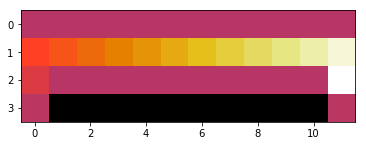

In [10]:
 for learning_method in ["QL", "SARSA"]:

    agent = Agent([4,12], learning_method) #create an agent that also creates the enviroment

    best_score = -np.inf
    best_episode = []
    total_score = 0

    agent.print_method() #print method name

    for i in range(total_episodes):
        episode, score, done = agent.generate_episode()  #generate an episode and return the results
        total_score += score

        if score > best_score: #log the best score and episode history
            best_score = score
            best_episode = episode

        agent.test(i) #every eval_frequency episodes test our policy
        #agent.reduce_epsilon()

    agent.print_best(best_score) #print best score
    #agent.print_game(best_episode) #show history of best episode
    print("Average of scores during training:", total_score/total_episodes) #print average training score
    
    print("Episode run using the greedy policy and the final action-value function")
    history, score, done = agent.generate_test_episode()
    agent.print_game(history) #show history of test episode
        